Raw Data Range
Theta1: min = -119.42328040329392 , max = 119.97815986283119
Theta2: min = -14871.202012283089 , max = 1498.9634674435285
Normalized Data Range
Min = 0.0 , Max = 1.0


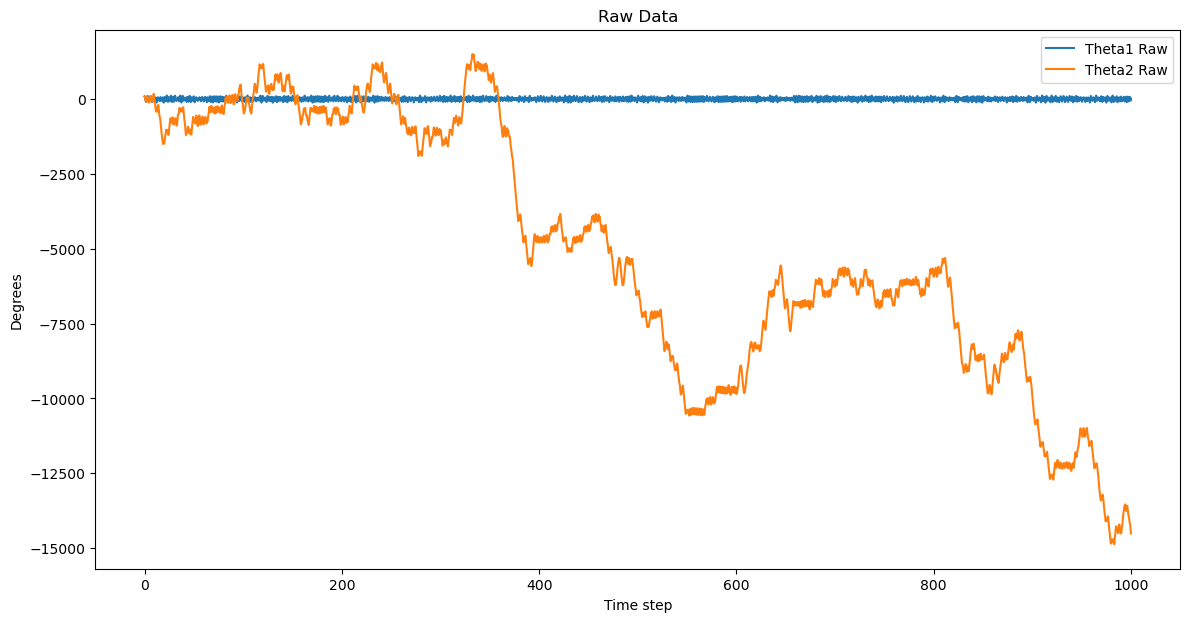

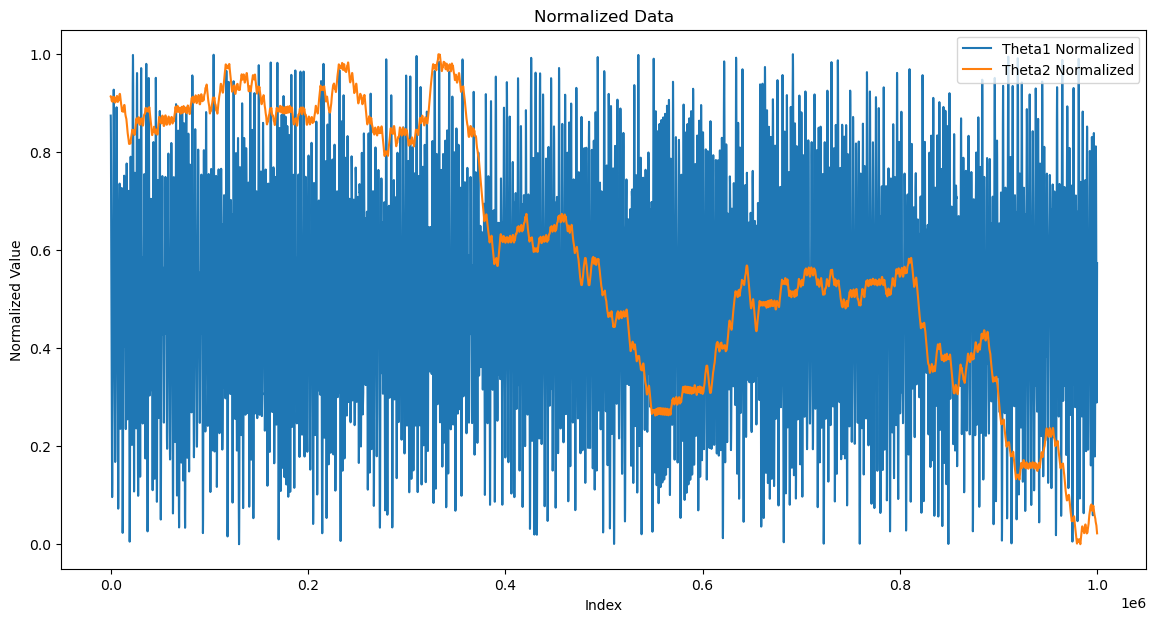

Data shape: (1000000, 2)
First few rows of data:
[[0.8747787  0.91393102]
 [0.87477752 0.91393102]
 [0.874774   0.91393102]
 [0.87476813 0.91393102]
 [0.87475992 0.91393102]]
Epoch 1, Train Loss: 0.10595468694565774, Test Loss: 0.0017554909682021417
Epoch 2, Train Loss: 0.0005761794302406563, Test Loss: 9.156804913129571e-05
Epoch 3, Train Loss: 3.559283068075268e-05, Test Loss: 1.598116489907082e-05
Epoch 4, Train Loss: 1.0632073059182172e-05, Test Loss: 6.851956068489783e-06
Epoch 5, Train Loss: 5.016789692425102e-06, Test Loss: 3.5055075789072065e-06
Epoch 6, Train Loss: 2.6262716718784947e-06, Test Loss: 1.885386176315384e-06
Epoch 7, Train Loss: 1.4230838064722216e-06, Test Loss: 1.0550870192919196e-06
Epoch 8, Train Loss: 7.99434473663009e-07, Test Loss: 5.94268593192686e-07
Epoch 9, Train Loss: 4.840190408491042e-07, Test Loss: 3.772353828839462e-07
Epoch 10, Train Loss: 3.2416864955899457e-07, Test Loss: 2.694493589316416e-07
Epoch 11, Train Loss: 2.3508731025660522e-07, Test L

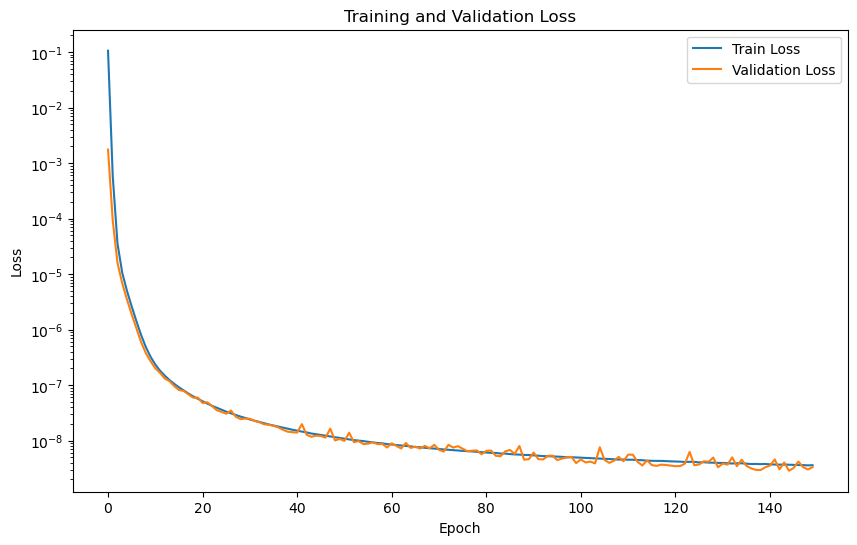

Test RMSE: 5.7535894368414774e-05
R^2 Score: 0.9999999456931781


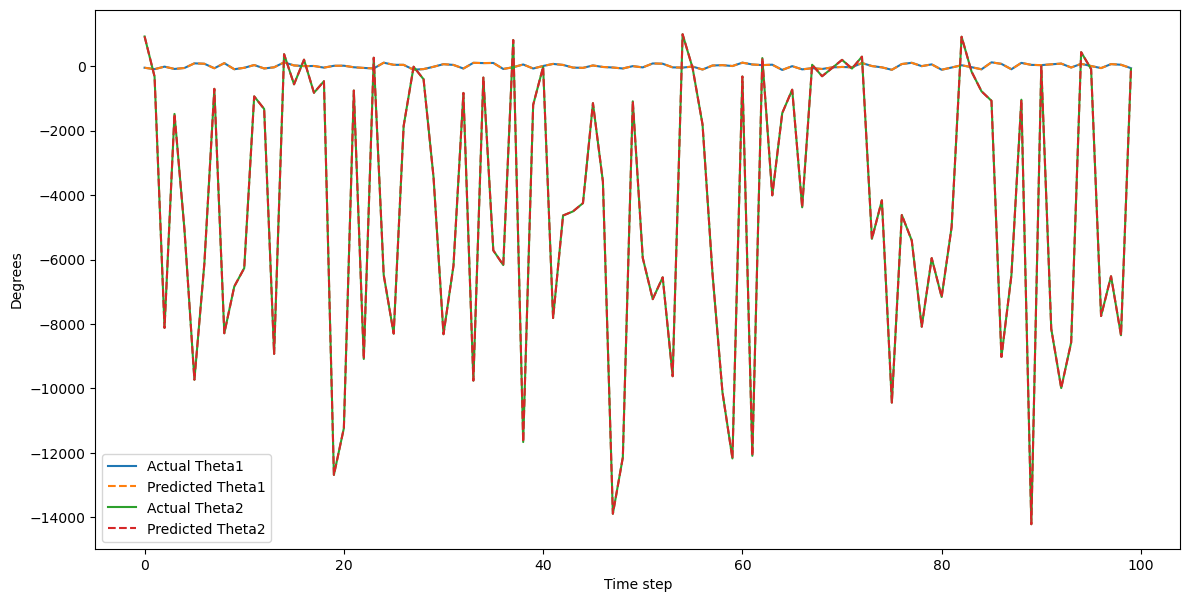

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Differential equation solver
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * np.sin(theta1) - m2 * g * np.sin(theta1 - 2 * theta2) - 2 * np.sin(theta1 - theta2) * m2 * 
               (omega2**2 * L2 + omega1**2 * L1 * np.cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * np.cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * np.sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * np.cos(theta1) + omega2**2 * L2 * m2 * 
                                           np.cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * np.cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

# Generate pendulum data
a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi
    theta2_points[i] = q[2] * 180 / np.pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

data = np.stack((theta1_points, theta2_points), axis=1)

print("Raw Data Range")
print("Theta1: min =", theta1_points.min(), ", max =", theta1_points.max())
print("Theta2: min =", theta2_points.min(), ", max =", theta2_points.max())


scaler = MinMaxScaler()
data = scaler.fit_transform(data)

print("Normalized Data Range")
print("Min =", data.min(), ", Max =", data.max())

plt.figure(figsize=(14, 7))
plt.plot(tpoints, theta1_points, label='Theta1 Raw')
plt.plot(tpoints, theta2_points, label='Theta2 Raw')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.title('Raw Data')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data[:, 0], label='Theta1 Normalized')
plt.plot(data[:, 1], label='Theta2 Normalized')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.title('Normalized Data')
plt.show()

print("Data shape:", data.shape)
print("First few rows of data:")
print(data[:5])


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 100
X, y = create_sequences(data, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=150, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2
hidden_layer_size = 50  # Increased hidden layer size
output_size = 2

model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)

# Initialize weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
         nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='relu')
    elif 'bias' in name:
        nn.init.uniform_(param, -0.1, 0.1)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Reduced learning rate

train_losses = []
test_losses = []

PATIENCE = 10

def train_model(model, train_loader, test_loader, num_epochs):
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for sequences, targets in test_loader:
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
        
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_without_improvement = 0
            best_model_wts = model.state_dict()
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    model.load_state_dict(best_model_wts)

NUM_EPOCHS = 150
train_model(model, train_loader, test_loader, NUM_EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            all_preds.append(y_pred)
            all_targets.append(targets)
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test RMSE: {avg_test_loss}')
    
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()
    
    r2 = r2_score(all_targets, all_preds)
    print(f'R^2 Score: {r2}')

evaluate_model(model, test_loader)

# Predict and plot results
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break

y_pred_np = y_pred.cpu().numpy()
targets_np = targets.cpu().numpy()

y_pred_original = scaler.inverse_transform(y_pred_np)
targets_original = scaler.inverse_transform(targets_np)

time_steps_to_plot = min(100, len(targets_original))

plt.figure(figsize=(14, 7))
plt.plot(targets_original[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(y_pred_original[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(targets_original[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(y_pred_original[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()
